In [2]:
%matplotlib inline
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input
from glob import glob
from itertools import cycle,zip_longest
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import json
import time
from sklearn.cluster import KMeans
import numpy as np
import lda
import collections
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib

## Data Processing - Create Batch Generator

In [2]:
#run extract_files.py to process the image files
total_image_number = 206900

## Process .json file with image labels 

In [3]:
def process_label_file():
    #with open("photos.json") as infile:
    with open("../photos.json") as infile:
      val = infile.readlines()

    id = []
    label = []
    for i in val:
      #print(i)
      #print("ID: %s, Label: %s" % (json.loads(i)['photo_id'],json.loads(i)['label']))
      id.append(json.loads(i)['photo_id'])
      label.append(json.loads(i)['label'])
    id = np.asarray(id)
    label = np.asarray(label)
    info = np.vstack((id,label))
    info = info.T
    info[0,:]
    return info

In [4]:
#align images with labels in used_im_labels array
def map_label_file_to_names(json_labels,names):
    process_names = names
    new_names = [(name.replace("/home/ubuntu/project/le49/photos/","")).replace(".jpg","") for name in process_names]
    used_im_labels = [json_labels[np.where(json_labels[:,0]==name)[0][0],1] for name in new_names]
    return np.asarray(used_im_labels)

In [5]:
info = process_label_file()

In [6]:
#data is saved, uncomment if need to re-generate
#used_im_labels = map_label_file_to_names(info,names)
#np.save('labels.npy', used_im_labels) 

In [7]:
used_im_labels = np.load('labels.npy')

In [8]:
#unique elements in json file i.e. food, drink, inside, outside and menu
uniq_elem = np.unique(info[:,1])

## Define Model

In [9]:
# refer to extract_files.py for model definiton

## Load Extracted Features
These are extracted using extract_files.py and saved into .npy files for speed

In [9]:
#refer to extract_files.py for creation of these files
names = np.load('names.npy')

In [10]:
final_features_b2_av = np.load('predictions_block2_global.npy')

In [11]:
final_features_b5_av = np.load('predictions_block5_global.npy')

In [12]:
final_features_b2_max = np.load('predictions_block2_max.npy')

In [13]:
final_features_b5_max = np.load('predictions_block5_max.npy')

## Process features into word representations

** Process by normalising the rows and setting values > 0.5 to 1 otherwise 0 **

In [25]:
def process_features_with_normalising(final_features):
    processed_features_list = []
    mean = np.mean(final_features,axis=1)
    min = np.min(final_features,axis=1)
    max = np.max(final_features,axis=1)
    for row in range(final_features.shape[0]):
      if((100*row/final_features.shape[0]) % 10 == 0 and int(100*row/final_features.shape[0]) !=0):
          print("%s" % (int(100*row/final_features.shape[0])))
      normalised_row = [(image-min[row])/(max[row]-min[row]) for image in final_features[row,:]]
      discrete_row = [1 if image >= 0.5 else 0 for image in normalised_row]
      final_array_row = np.asarray(discrete_row)
      processed_features_list.append(final_array_row)
    return np.asarray(processed_features_list)

In [ ]:
#data is saved, uncomment if need to re-run
#processed_features_b5_av_norm = process_features_with_normalising(final_features_b5_av)
#processed_features_b5_max_norm = process_features_with_normalising(final_features_b5_max)
#processed_features_b2_av_norm = process_features_with_normalising(final_features_b2_av)
#processed_features_b2_max_norm = process_features_with_normalising(final_features_b2_max)

In [27]:
#np.save('processed_features_b5_av_norm.npy', processed_features_b5_av_norm) 
#np.save('processed_features_b5_max_norm.npy', processed_features_b5_max_norm) 
#np.save('processed_features_b2_av_norm.npy', processed_features_b2_av_norm) 
#np.save('processed_features_b2_max_norm.npy', processed_features_b2_max_norm) 

In [142]:
#processed_features_b5_av_norm = np.load('processed_features_b5_av_norm.npy')
#processed_features_b5_max_norm = np.load('processed_features_b5_max_norm.npy')
#processed_features_b2_av_norm = np.load('processed_features_b2_av_norm.npy')
#processed_features_b2_max_norm = np.load('processed_features_b2_max_norm.npy')

In [14]:
def process_features_with_counts(final_features):
    num_features = final_features.shape[1]
    return np.reshape(np.round(np.reshape(final_features,(total_image_number*num_features))),(total_image_number,num_features)).astype(int)

In [21]:
#data is saved, uncomment if need to re-run
#processed_features_b5_av_counts = process_features_with_counts(final_features_b5_av)
#processed_features_b5_max_counts = process_features_with_counts(final_features_b5_max)
#processed_features_b2_av_counts = process_features_with_counts(final_features_b2_av)
#processed_features_b2_max_counts = process_features_with_counts(final_features_b2_max)

In [22]:
#np.save('processed_features_b5_av_counts.npy', processed_features_b5_av_counts) 
#np.save('processed_features_b5_max_counts.npy', processed_features_b5_max_counts) 
#np.save('processed_features_b2_av_counts.npy', processed_features_b2_av_counts) 
#np.save('processed_features_b2_max_counts.npy', processed_features_b2_max_counts) 

In [18]:
processed_features_b5_av_counts = np.load('processed_features_b5_av_counts.npy')
processed_features_b5_max_counts = np.load('processed_features_b5_max_counts.npy')
processed_features_b2_av_counts = np.load('processed_features_b2_av_counts.npy')
processed_features_b2_max_counts = np.load('processed_features_b2_max_counts.npy')

In [16]:
def regenerate_random_data_samples(total_samples,random_subset, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    final_subset = features[random_subset][0,:,:]
    final_labels = used_im_labels[random_subset][0]
    final_names = names[random_subset][0]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names


In [74]:
def generate_random_data_samples(total_samples, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    random_subset = np.random.choice(range(0,processed_features.shape[0]), size=(total_samples), replace=False)
    final_subset = features[random_subset]
    final_labels = used_im_labels[random_subset]
    final_names = names[random_subset]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names



In [57]:
#final_subset, final_labels, random_subset, names_subset= generate_random_data_samples(2000)

In [19]:
#to see the names of the files used refer to "names_of_data_files_used.txt"
random_subset = np.load("subset_test1.npy") #~1% data (same distribution)! 

** Define all features for the subset data samples for the different configurations **

In [20]:
final_subset_b5_av, final_labels, random_subset_val, names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_av_counts) # max 894


In [24]:
final_subset_b5_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_max_counts) # max 894



In [25]:
final_subset_b2_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_av_counts) # max 894 


In [26]:
final_subset_b2_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_max_counts) # max 894 

## Do LDA on word representations

In [106]:
#alpha = 0.1 default
num_topics = 10

model_lda_b5_av_10 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_10.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_10.npy",model_lda_b5_av_10.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_10.npy",model_lda_b5_av_10.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_10.npy",model_lda_b5_av_10.ndz_)

model_lda_b2_av_10 = lda.LDA(n_topics=num_topics, n_iter=300, random_state=1)
model_lda_b2_av_10.fit(final_subset_b2_av)

np.save("./final_data/model_lda_b2_av_topic_c_10.npy",model_lda_b2_av_10.doc_topic_)
np.save("./final_data/model_lda_b2_av_comp_c_10.npy",model_lda_b2_av_10.components_)
np.save("./final_data/model_lda_b2_av_ndz_c_10.npy",model_lda_b2_av_10.ndz_)

model_lda_b5_max_10 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_max_10.fit(final_subset_b5_max)

np.save("./final_data/model_lda_b5_max_topic_c_10.npy",model_lda_b5_max_10.doc_topic_)
np.save("./final_data/model_lda_b5_max_comp_c_10.npy",model_lda_b5_max_10.components_)
np.save("./final_data/model_lda_b5_max_ndz_c_10.npy",model_lda_b5_max_10.ndz_)

num_topics = 5

model_lda_b5_av_5 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_5.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_5.npy",model_lda_b5_av_5.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_5.npy",model_lda_b5_av_5.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_5.npy",model_lda_b5_av_5.ndz_)

num_topics = 40

model_lda_b5_av_40 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_40.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_40.npy",model_lda_b5_av_40.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_40.npy",model_lda_b5_av_40.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_40.npy",model_lda_b5_av_40.ndz_)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 10
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -11825579
INFO:lda:<10> log likelihood: -10270070
INFO:lda:<20> log likelihood: -9505633
INFO:lda:<30> log likelihood: -9395627
INFO:lda:<40> log likelihood: -9366753
INFO:lda:<50> log likelihood: -9353794
INFO:lda:<60> log likelihood: -9340585
INFO:lda:<70> log likelihood: -9335543
INFO:lda:<80> log likelihood: -9331000
INFO:lda:<90> log likelihood: -9328905
INFO:lda:<100> log likelihood: -9324009
INFO:lda:<110> log likelihood: -9324179
INFO:lda:<120> log likelihood: -9324403
INFO:lda:<130> log likelihood: -9324002
INFO:lda:<140> log likelihood: -9320415
INFO:lda:<149> log likelihood: -9320639
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 128
INFO:lda:n_words: 33874886
INFO:lda:n_topics: 10
INFO:lda:n_iter: 300
INFO:lda:<0> log likelihood: -240159529
INFO:lda:<10> log likelihood: -239492664
INFO:lda:<20> log likelihood: -234599367
INFO

In [24]:
topics = np.array([5,10,15,20,30,40,50,60])
log_likelihoods = np.zeros([8])

for i,topic in enumerate(topics):
    model_lda_b5_av = lda.LDA(n_topics=topic, n_iter=150, random_state=1)
    model_lda_b5_av.fit(final_subset_b5_av)
    log_likelihoods[i] = model_lda_b5_av.loglikelihood()
    print("Complete topic %s" % (topic))

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 5
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -10790067
INFO:lda:<10> log likelihood: -9708041
INFO:lda:<20> log likelihood: -9172314
INFO:lda:<30> log likelihood: -9093563
INFO:lda:<40> log likelihood: -9073675
INFO:lda:<50> log likelihood: -9065601
INFO:lda:<60> log likelihood: -9060067
INFO:lda:<70> log likelihood: -9060490
INFO:lda:<80> log likelihood: -9058988
INFO:lda:<90> log likelihood: -9054914
INFO:lda:<100> log likelihood: -9055787
INFO:lda:<110> log likelihood: -9056951
INFO:lda:<120> log likelihood: -9052060
INFO:lda:<130> log likelihood: -9052189
INFO:lda:<140> log likelihood: -9049442
INFO:lda:<149> log likelihood: -9052175
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 10
INFO:lda:n_iter: 150


Complete topic 5


INFO:lda:<0> log likelihood: -11825579
INFO:lda:<10> log likelihood: -10270070
INFO:lda:<20> log likelihood: -9505633
INFO:lda:<30> log likelihood: -9395627
INFO:lda:<40> log likelihood: -9366753
INFO:lda:<50> log likelihood: -9353794
INFO:lda:<60> log likelihood: -9340585
INFO:lda:<70> log likelihood: -9335543
INFO:lda:<80> log likelihood: -9331000
INFO:lda:<90> log likelihood: -9328905
INFO:lda:<100> log likelihood: -9324009
INFO:lda:<110> log likelihood: -9324179
INFO:lda:<120> log likelihood: -9324403
INFO:lda:<130> log likelihood: -9324002
INFO:lda:<140> log likelihood: -9320415
INFO:lda:<149> log likelihood: -9320639
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 15
INFO:lda:n_iter: 150


Complete topic 10


INFO:lda:<0> log likelihood: -12447979
INFO:lda:<10> log likelihood: -10691088
INFO:lda:<20> log likelihood: -9736071
INFO:lda:<30> log likelihood: -9580697
INFO:lda:<40> log likelihood: -9529607
INFO:lda:<50> log likelihood: -9502394
INFO:lda:<60> log likelihood: -9488244
INFO:lda:<70> log likelihood: -9466399
INFO:lda:<80> log likelihood: -9459361
INFO:lda:<90> log likelihood: -9452934
INFO:lda:<100> log likelihood: -9445038
INFO:lda:<110> log likelihood: -9443983
INFO:lda:<120> log likelihood: -9436068
INFO:lda:<130> log likelihood: -9435896
INFO:lda:<140> log likelihood: -9432376
INFO:lda:<149> log likelihood: -9428889
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 20
INFO:lda:n_iter: 150


Complete topic 15


INFO:lda:<0> log likelihood: -12900527
INFO:lda:<10> log likelihood: -10799167
INFO:lda:<20> log likelihood: -9848584
INFO:lda:<30> log likelihood: -9686467
INFO:lda:<40> log likelihood: -9629614
INFO:lda:<50> log likelihood: -9596590
INFO:lda:<60> log likelihood: -9574400
INFO:lda:<70> log likelihood: -9557261
INFO:lda:<80> log likelihood: -9549246
INFO:lda:<90> log likelihood: -9536001
INFO:lda:<100> log likelihood: -9534773
INFO:lda:<110> log likelihood: -9529436
INFO:lda:<120> log likelihood: -9520227
INFO:lda:<130> log likelihood: -9521412
INFO:lda:<140> log likelihood: -9514899
INFO:lda:<149> log likelihood: -9510975
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 30
INFO:lda:n_iter: 150


Complete topic 20


INFO:lda:<0> log likelihood: -13559288
INFO:lda:<10> log likelihood: -10987289
INFO:lda:<20> log likelihood: -10004009
INFO:lda:<30> log likelihood: -9822979
INFO:lda:<40> log likelihood: -9750340
INFO:lda:<50> log likelihood: -9714769
INFO:lda:<60> log likelihood: -9682571
INFO:lda:<70> log likelihood: -9668171
INFO:lda:<80> log likelihood: -9655944
INFO:lda:<90> log likelihood: -9646121
INFO:lda:<100> log likelihood: -9630281
INFO:lda:<110> log likelihood: -9626755
INFO:lda:<120> log likelihood: -9613873
INFO:lda:<130> log likelihood: -9609469
INFO:lda:<140> log likelihood: -9603548
INFO:lda:<149> log likelihood: -9596002
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 40
INFO:lda:n_iter: 150


Complete topic 30


INFO:lda:<0> log likelihood: -14045872
INFO:lda:<10> log likelihood: -11093943
INFO:lda:<20> log likelihood: -10105852
INFO:lda:<30> log likelihood: -9907743
INFO:lda:<40> log likelihood: -9824363
INFO:lda:<50> log likelihood: -9775896
INFO:lda:<60> log likelihood: -9745943
INFO:lda:<70> log likelihood: -9725074
INFO:lda:<80> log likelihood: -9703598
INFO:lda:<90> log likelihood: -9686318
INFO:lda:<100> log likelihood: -9672441
INFO:lda:<110> log likelihood: -9668808
INFO:lda:<120> log likelihood: -9659340
INFO:lda:<130> log likelihood: -9651370
INFO:lda:<140> log likelihood: -9645114
INFO:lda:<149> log likelihood: -9641498
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 50
INFO:lda:n_iter: 150


Complete topic 40


INFO:lda:<0> log likelihood: -14437176
INFO:lda:<10> log likelihood: -11134089
INFO:lda:<20> log likelihood: -10158378
INFO:lda:<30> log likelihood: -9954557
INFO:lda:<40> log likelihood: -9869149
INFO:lda:<50> log likelihood: -9814095
INFO:lda:<60> log likelihood: -9779083
INFO:lda:<70> log likelihood: -9752702
INFO:lda:<80> log likelihood: -9734737
INFO:lda:<90> log likelihood: -9720115
INFO:lda:<100> log likelihood: -9699267
INFO:lda:<110> log likelihood: -9692986
INFO:lda:<120> log likelihood: -9680847
INFO:lda:<130> log likelihood: -9670938
INFO:lda:<140> log likelihood: -9663551
INFO:lda:<149> log likelihood: -9660369
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 60
INFO:lda:n_iter: 150


Complete topic 50


INFO:lda:<0> log likelihood: -14767763
INFO:lda:<10> log likelihood: -11237647
INFO:lda:<20> log likelihood: -10259144
INFO:lda:<30> log likelihood: -10049551
INFO:lda:<40> log likelihood: -9958351
INFO:lda:<50> log likelihood: -9896385
INFO:lda:<60> log likelihood: -9853109
INFO:lda:<70> log likelihood: -9821446
INFO:lda:<80> log likelihood: -9791664
INFO:lda:<90> log likelihood: -9774350
INFO:lda:<100> log likelihood: -9758922
INFO:lda:<110> log likelihood: -9747648
INFO:lda:<120> log likelihood: -9738798
INFO:lda:<130> log likelihood: -9727094
INFO:lda:<140> log likelihood: -9716648
INFO:lda:<149> log likelihood: -9707184


Complete topic 60


In [ ]:
topics2 = np.array([70,100,150,200])
log_likelihoods2 = np.zeros([4])
for i,topic in enumerate(topics2):
    model_lda_b5_av = lda.LDA(n_topics=topic, n_iter=150, random_state=1)
    model_lda_b5_av.fit(final_subset_b5_av)
    log_likelihoods[i] = model_lda_b5_av.loglikelihood()
    print("Complete topic %s" % (topic))

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 70
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -15056603
INFO:lda:<10> log likelihood: -11219185
INFO:lda:<20> log likelihood: -10268423
INFO:lda:<30> log likelihood: -10060658
INFO:lda:<40> log likelihood: -9965497
INFO:lda:<50> log likelihood: -9906709
INFO:lda:<60> log likelihood: -9863342
INFO:lda:<70> log likelihood: -9835213
INFO:lda:<80> log likelihood: -9812126
INFO:lda:<90> log likelihood: -9795660
INFO:lda:<100> log likelihood: -9778692
INFO:lda:<110> log likelihood: -9767106
INFO:lda:<120> log likelihood: -9754340
INFO:lda:<130> log likelihood: -9747297
INFO:lda:<140> log likelihood: -9734574
INFO:lda:<149> log likelihood: -9728741
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 100
INFO:lda:n_iter: 150


Complete topic 70


INFO:lda:<0> log likelihood: -15759227
INFO:lda:<10> log likelihood: -11307057
INFO:lda:<20> log likelihood: -10396359
INFO:lda:<30> log likelihood: -10173051
INFO:lda:<40> log likelihood: -10060907
INFO:lda:<50> log likelihood: -9989601
INFO:lda:<60> log likelihood: -9932192
INFO:lda:<70> log likelihood: -9897068
INFO:lda:<80> log likelihood: -9870671
INFO:lda:<90> log likelihood: -9844414
INFO:lda:<100> log likelihood: -9830535
INFO:lda:<110> log likelihood: -9813094
INFO:lda:<120> log likelihood: -9802161
INFO:lda:<130> log likelihood: -9792705
INFO:lda:<140> log likelihood: -9779850
INFO:lda:<149> log likelihood: -9770107
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 150
INFO:lda:n_iter: 150


Complete topic 100


INFO:lda:<0> log likelihood: -16635919
INFO:lda:<10> log likelihood: -11388838
INFO:lda:<20> log likelihood: -10509378
INFO:lda:<30> log likelihood: -10279748
INFO:lda:<40> log likelihood: -10149430
INFO:lda:<50> log likelihood: -10062316
INFO:lda:<60> log likelihood: -10005409
INFO:lda:<70> log likelihood: -9967849
INFO:lda:<80> log likelihood: -9933398
INFO:lda:<90> log likelihood: -9904973
INFO:lda:<100> log likelihood: -9888155
INFO:lda:<110> log likelihood: -9864031
INFO:lda:<120> log likelihood: -9853186
INFO:lda:<130> log likelihood: -9846438
INFO:lda:<140> log likelihood: -9834967
INFO:lda:<149> log likelihood: -9826694
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 200
INFO:lda:n_iter: 150


Complete topic 150


INFO:lda:<0> log likelihood: -17319706
INFO:lda:<10> log likelihood: -11465282
INFO:lda:<20> log likelihood: -10602561
INFO:lda:<30> log likelihood: -10350685
INFO:lda:<40> log likelihood: -10210535
INFO:lda:<50> log likelihood: -10126116
INFO:lda:<60> log likelihood: -10068934
INFO:lda:<70> log likelihood: -10025272
INFO:lda:<80> log likelihood: -9992034
INFO:lda:<90> log likelihood: -9965753
INFO:lda:<100> log likelihood: -9945097


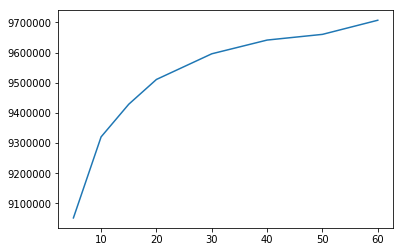

In [26]:
plt.plot(topics, -1*log_likelihoods)

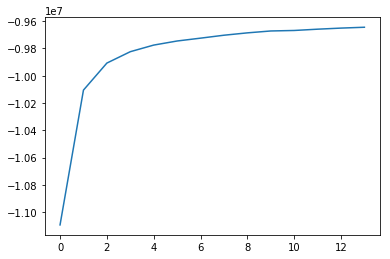

In [111]:
plt.plot(model_lda_b5_av_40.loglikelihoods_[1:])

In [112]:
def calculate_mean_std_dirichlet_distribution(model_ndz):
    results = np.zeros([1000,2000,model_ndz.shape[1]])
    for i in range(0,1000):
        for j in range(0,2000):
            results[i,j,:] = np.random.dirichlet(model_ndz[j,:]+0.1)
    return np.mean(results,axis=0),np.std(results,axis=0)

In [129]:
#model = np.load("./final_data/model_lda_b5_av_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b2_av_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b5_max_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b5_av_ndz_c_5.npy")
#model = np.load("./final_data/model_lda_b5_av_ndz_c_40.npy")

In [130]:
std = np.reshape(calculate_mean_std_dirichlet_distribution(model)[1],(model.shape[0]*model.shape[1]))

(array([1.94113200e+02, 3.26427123e+01, 2.73197384e+01, 1.48716878e+01,
        5.88895225e+00, 2.16321772e+00, 6.52784802e-01, 1.11112307e-01,
        1.38890383e-02, 3.47225958e-03]),
 array([0.00017295, 0.00377292, 0.00737288, 0.01097284, 0.0145728 ,
        0.01817276, 0.02177272, 0.02537268, 0.02897264, 0.03257261,
        0.03617257]),
 <a list of 10 Patch objects>)

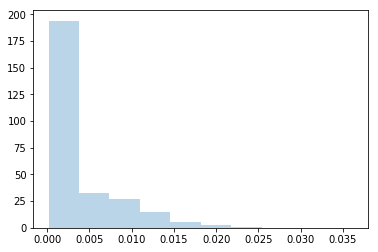

In [131]:
plt.hist(std,bins=10,alpha = 0.3,normed=True)

In [132]:
#np.save("./final_data/std_lda_b5_av_c_10.npy",std)
#np.save("./final_data/std_lda_b2_av_c_10.npy",std)
#np.save("./final_data/std_lda_b5_max_c_10.npy",std)
#np.save("./final_data/std_lda_b5_av_c_5.npy",std)
#np.save("./final_data/std_lda_b5_av_c_40.npy",std)

In [26]:
stds40 = stds

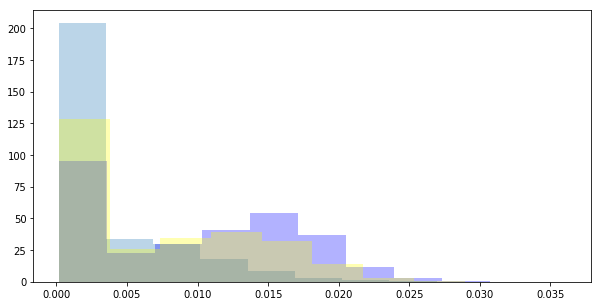

In [101]:
plt.figure(figsize=(10, 5))
plt.hist(np.reshape(stds40,(2000*40)),bins=10,alpha = 0.3,normed=True)
plt.hist(np.reshape(stds5,(2000*5)),bins=10,alpha = 0.3,normed=True,color='blue')
plt.hist(np.reshape(stds10,(2000*10)),bins=10,alpha = 0.3,normed=True,color='yellow')
plt.show()

In [133]:
print(model_lda_b5_av_10.loglikelihood())
print(model_lda_b2_av_10.loglikelihood())
print(model_lda_b5_max_10.loglikelihood())
print(model_lda_b5_av_5.loglikelihood())
print(model_lda_b5_av_40.loglikelihood())

-9320639.49330952
-206291392.98282573
-213789558.9091874
-9052175.181839911
-9641497.959669007


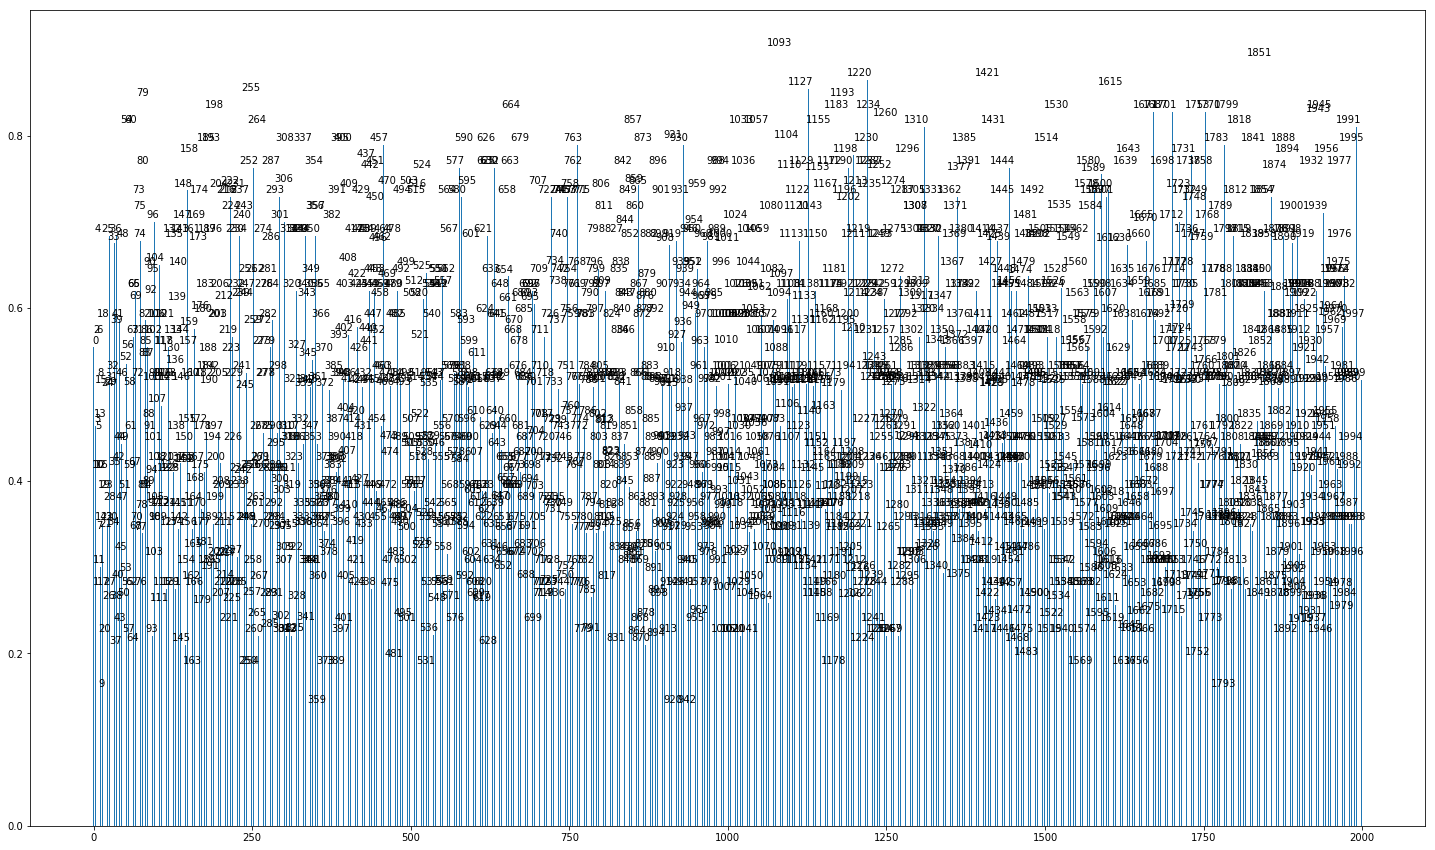

In [80]:
plt.figure(figsize=(25, 15))
all_points = np.array(range(0,2000))
plt.bar(range(0,2000),np.max(model_lda.doc_topic_,axis=1),width=0.3)
for i,label in enumerate(range(0,2000)):
    x = all_points[i]
    y = np.max(model_lda.doc_topic_,axis=1)[i]
    plt.annotate(i,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



** Plot Convergence of LDA **

In [369]:
model_lda_b5_av.loglikelihoods_[1:]

[-10270070.211481115,
 -9505632.603808338,
 -9395626.68739217,
 -9366752.757704495,
 -9353793.756832907,
 -9340584.82609745,
 -9335542.995463355,
 -9331000.177283911,
 -9328904.780165762,
 -9324008.848883342,
 -9324179.287879717,
 -9324403.474116823,
 -9324001.969559964,
 -9320415.00320904]

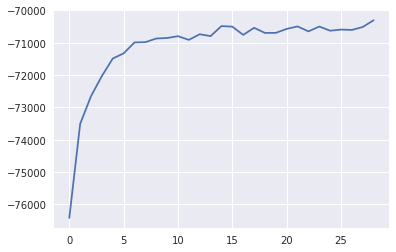

In [177]:
plt.plot(model_lda_b5_av.loglikelihoods_[1:])

In [218]:
topic_b5_av_c = np.load("model_lda_b5_av_topic_c.npy")
topic_b5_max_c = np.load("model_lda_b5_max_topic_c.npy")
topic_b5_av_c_comp = np.load("model_lda_b5_av_comp_c.npy")
topic_b5_max_c_comp = np.load("model_lda_b5_av_comp_c.npy")
topic_b5_av_n_comp = np.load("model_lda_b5_av_comp_n.npy")
topic_b5_max_n_comp = np.load("model_lda_b5_max_comp_n.npy")
#np.save("model_lda_b5_max_topic_c.npy",model_lda_b5_max.doc_topic_)
#np.save("model_lda_b5_av_comp_c.npy",model_lda_b5_av.components_)
#np.save("model_lda_b5_av_comp_c.npy",model_lda_b5_max.components_)

In [ ]:
topic_b5_av_n_comp = np.load("model_lda_b5_av_comp_n.npy")
#np.save("model_lda_b5_max_comp_n.npy",model_lda_b5_max.components_)

In [461]:
adjusted_rand_score(np.argmax(model_lda_b5_av.doc_topic_,axis=1),np.argmax(model_lda_b2_av.doc_topic_,axis=1))

0.04802338540627367

In [148]:
prediction_b5_av = np.argmax(model_lda_b5_av.doc_topic_,axis=1)

In [149]:
prediction_b5_max = np.argmax(model_lda_b5_max.doc_topic_,axis=1)

In [94]:
from sklearn.metrics.cluster import adjusted_rand_score

In [150]:
adjusted_rand_score(prediction_b5_av,prediction_b5_max)

0.27228260253681874

In [151]:
sklearn.metrics.cluster.adjusted_rand_score(prediction_b5_max,prediction_b5_av)

0.27228260253681874

In [182]:
model_lda.nzw_.shape

(20, 512)

In [205]:
model_lda.ndz_

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [219]:
model_lda.ndz_[0,:]

array([2, 0, 0, 6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [157]:
model_lda.components_[0,:].shape

(128,)

<Container object of 128 artists>

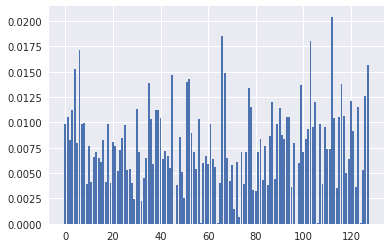

In [158]:
plt.bar(range(0,128),model_lda.components_[0,:])

<Container object of 512 artists>

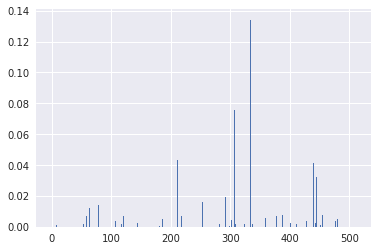

In [217]:
plt.bar(range(0,512),topic_b5_av_n_comp[0,:])

<Container object of 512 artists>

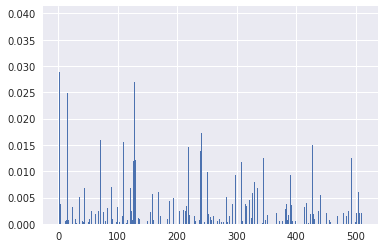

In [219]:
plt.bar(range(0,512),topic_b5_av_c_comp[0,:])

In [216]:
topic_b5_av_n_comp[0,:].shape

(512,)

<Container object of 10 artists>

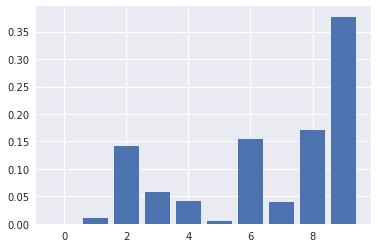

In [159]:
plt.bar(range(0,10),model_lda.doc_topic_[0,:])

In [48]:
np.sum([topic_prob*(np.exp(np.sum(np.log(model_lda.components_[i,:])))) for i,topic_prob in enumerate(model_lda.doc_topic_[4,:])])


0.0

In [38]:
plt.bar(range(0,512),model_lda.components_[0,:])

0.0

In [45]:
np.sum(np.log(model_lda.components_[0,:]))

-5120.89096793468

In [29]:
2 ** (-np.log2(val)/np.sum(processed_features_subset[0,:]))

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


inf

In [19]:
-np.log2(val)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


inf

In [181]:
#perplexity - 2^(-log2(prob)/n)
all_perplexity_per_doc = []
for doc in range(0,2000):
    perplexity_per_doc = np.sum([topic_prob*np.prod(model_lda.components_[i,:]) for i,topic_prob in enumerate(model_lda.doc_topic_[doc,:])])
    print(perplexity_per_doc)
    all_perplexity_per_doc.append(2 ** (-np.log2(perplexity_per_doc)/np.sum(processed_features_subset[doc,:])))
    #perplexity = 2 ** (-np.log2(perplexity_per_doc)/np.sum(processed_features_subset[doc,:]))
all_perplexity_per_doc = np.asarray(all_perplexity_per_doc)

3.154621081731969e-293
1.9355675351955857e-288
3.143540899282721e-288
3.373492029290696e-288
2.1748406880018302e-288
1.3078530675159009e-288
2.3456127679332643e-288
8.314832433319354e-289
2.2567004598888977e-288
2.4812126947146744e-288
1.6049040990913002e-288
1.6751812795768037e-288
2.0561635054981393e-288
3.290813990051419e-288
3.665931911112846e-288
1.8984097507500043e-288
1.5905709020473576e-288
2.8803916678532753e-288
1.0142642151410523e-288
1.9577814609677105e-288
2.9423433811623294e-288
2.8134174974278256e-288
1.8691377874266117e-288
5.626045390075348e-289
1.2769758090552242e-288
3.87363152370286e-288
1.5871766482264715e-288
2.8594806338842665e-288
2.5410571903477528e-288
1.3399128085236282e-288
2.1168265402290116e-288
1.4774866956841603e-288
3.654399314606471e-288
1.2588687321310363e-288
1.9295999925304767e-288
2.309894632711319e-288
1.8418178089463277e-288
3.036462436652188e-288
3.301313868865471e-288
1.8318287477296123e-288
1.505053380651759e-288
2.1383642399089696e-288
2.6406

In [182]:
all_perplexity_per_doc.shape

(2000,)

(array([ 92., 478., 668., 482., 188.,  54.,  19.,  14.,   2.,   3.]),
 array([1.022563  , 1.02934272, 1.03612244, 1.04290216, 1.04968189,
        1.05646161, 1.06324133, 1.07002106, 1.07680078, 1.0835805 ,
        1.09036022]),
 <a list of 10 Patch objects>)

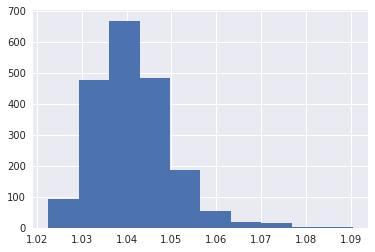

In [180]:
plt.hist(all_perplexity_per_doc)

## Visualisation of LDA wrt image labels

In [27]:
# RE-IMPLEMENT!!!
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(10, 10))  #in inches

    for i,label in enumerate(labels):
        
        x, y = lowDWeights[i,:]
        if label == 'menu': #negative
            plt.scatter(x, y,c='orange')
        elif label == 'drink': #neutral
            plt.scatter(x, y,c='green')
        elif label == 'inside': #neutral
            plt.scatter(x, y,c='blue')
        elif label == 'outside': #neutral
            plt.scatter(x, y,c='yellow')
        elif label == 'food': #neutral
            plt.scatter(x, y,c='purple')
        #plt.annotate(i,
        #         xy=(x, y),
        #         xytext=(5, 2),
        #       textcoords='offset points',
        #        ha='right',
        #         va='bottom')

    #plt.savefig(filename)

In [65]:
chr(0)

'\x00'

In [ ]:
def save_tsne_plot_as_txt(tsne_low_dim_rep,labels,fname):
    with open(fname, 'w') as f:
          f.write("x y l\n")
          for i in range(tsne_low_dim_rep.shape[0]):
            f.write("%s %s %s\n" %(tsne_low_dim_rep[i,0],tsne_low_dim_rep[i,1],chr(labels[i])))

In [22]:
model_lda_b5_av_topic_c_5 = np.load("./final_data/model_lda_b5_av_topic_c_5.npy")

In [23]:
tsne1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights1 = tsne1.fit_transform(model_lda_b5_av_topic_c_5)


In [168]:
tsne2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights2 = tsne2.fit_transform(model_lda_b5_av_40.doc_topic_)



In [30]:
#np.save("./final_data/tsne_weights_b5_av_c_p40_10.npy",lowDWeights1)
#np.save("./final_data/tsne_weights_b2_av_c_p40_10.npy",lowDWeights2)
#np.save("./final_data/tsne_weights_b5_max_c_p40_10.npy",lowDWeights1)
np.save("./final_data/tsne_weights_b5_av_c_p40_5.npy",lowDWeights1)
#np.save("./final_data/tsne_weights_b5_av_c_p40_40.npy",lowDWeights2)

In [31]:
labels = final_labels

In [139]:
final_labels.shape

(2000,)

In [140]:
new_labels = []
for label in labels:
    if label == 'menu': #negative
        new_labels.append(0)
    elif label == 'drink': #neutral
        new_labels.append(1)
    elif label == 'inside': #neutral
        new_labels.append(2)
    elif label == 'outside': #neutral
        new_labels.append(3)
    elif label == 'food': #neutral
        new_labels.append(4)
new_labels = np.asarray(new_labels)

In [24]:
labels2 = np.argmax(model_lda_b5_av_topic_c_5,axis=1)

In [188]:
#np.save("./final_data/labels_b5_av_c_p40_10.npy",labels2)
#np.save("./final_data/labels_b5_max_c_p40_10.npy",labels2)
np.save("./final_data/labels_b5_av_c_p40_5.npy",labels2)

In [185]:
labels3 = np.argmax(model_lda_b5_av_40.doc_topic_,axis=1)

In [186]:
#np.save("./final_data/labels_b2_av_c_p40_10.npy",labels3)
#np.save("./final_data/labels_b5_max_c_p40_10.npy",labels3)
np.save("./final_data/labels_b5_av_c_p40_40.npy",labels3)

In [39]:
collections.Counter(used_im_labels)

Counter({'drink': 6618,
         'food': 132325,
         'inside': 47948,
         'menu': 894,
         'outside': 19115})

In [46]:
100*894/206900#+132325+47948+894+19115

0.43209279845335913

In [162]:
class_count_b5_av_5 = collections.Counter(labels2)

In [147]:
class_count_b2_av

NameError: name 'class_count_b2_av' is not defined

In [172]:
class_count_b5_av_40 = collections.Counter(labels3)

In [149]:
class_count

NameError: name 'class_count' is not defined

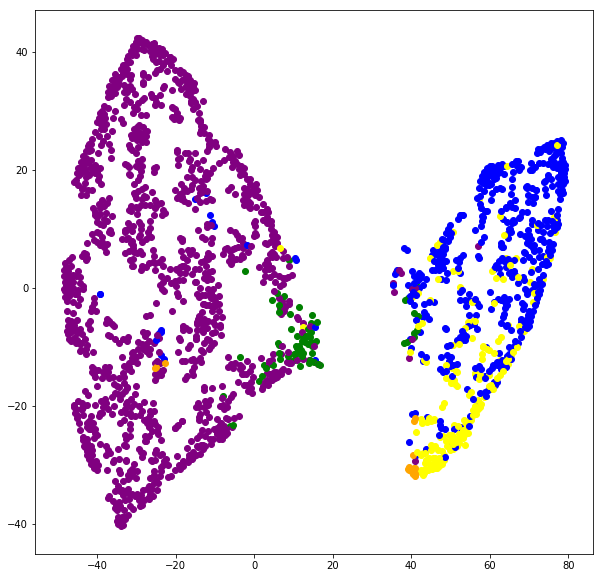

In [29]:
# 4 clusters p = 40
plot_with_labels(lowDWeights1, labels, str(1*100)+'.png')

MAX


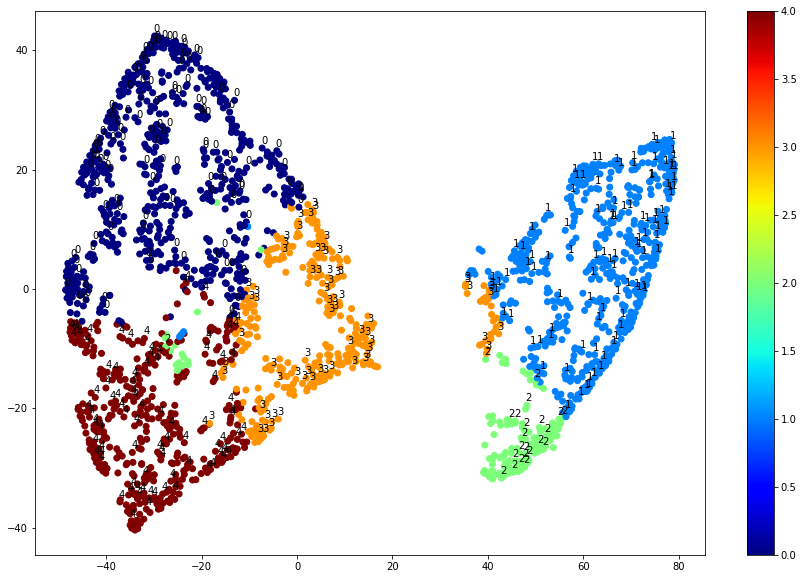

In [25]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("MAX")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=labels2,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
for i,label in enumerate(labels2):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



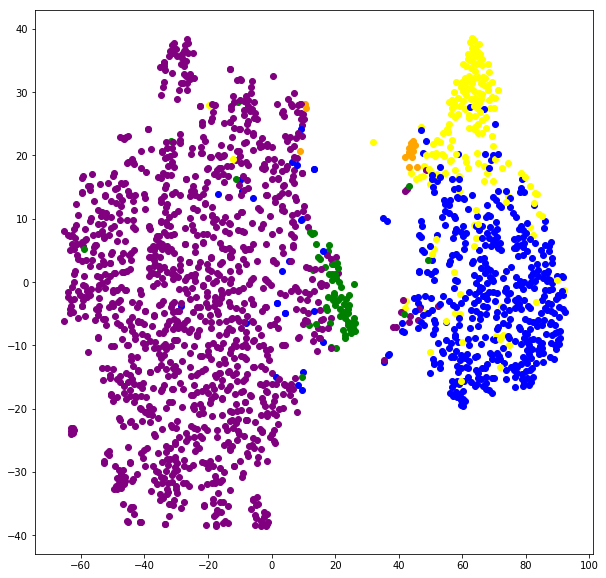

In [173]:
# 4 clusters p = 40
plot_with_labels(lowDWeights2, labels, str(1*100)+'.png')

AVERAGE


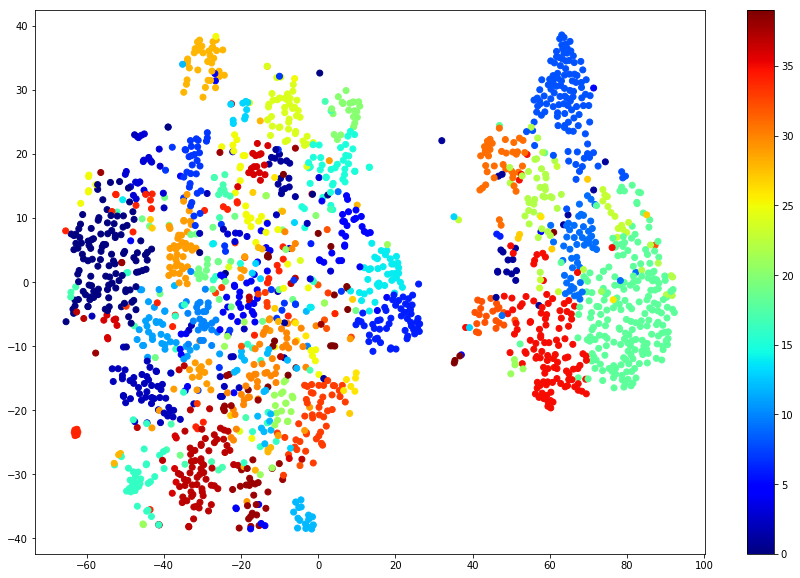

In [175]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("AVERAGE")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels3,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
for i,label in enumerate(labels3):
    x, y = lowDWeights2[i,:]
    #if(i%5 == 0):
    #   plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




b2 av
class 0 - black, brown, white
class 2 - very dark - bright in the middle
class 5 - white background
class 7 - red coloured
class 8 - white green red

b5 av
class 2 - drinks
class 3 - inside + dark
class 6 - circular shaped foods (dark background) (6 and 9 close together)
class 9 - circular shaped foods (light background)
class 7 - outside

b5 max

class 0 - drinks
class 1- circular shaped foods (general)
class 2 - outside
class 3 - food, bright green, white plates
class 8 - people
class 9 - mixture between inside and outside


b5 av (5)

class 2 - text, menu, signs
class 4 - circular shaped foods (general)
class 0 - non-circular food
class 1 - inside
class 3 - combo of drink and food

b5 av (40)

class 6 - drinks
class 31 - text, menu, signs (majority menu only)
class 29 - sandwiches, burgers
class 30 - food, square plates
class 2 - brown meat
category 12 - brown plates/ wraps
category 22 - inside (wood, chairs)
category 18 - inside (dark, chairs at tables)
category 28 - pizza

57
[34 24 43  5 47  6 38 22 29 55 30 35 39 42 19  9 36  1 32 11]


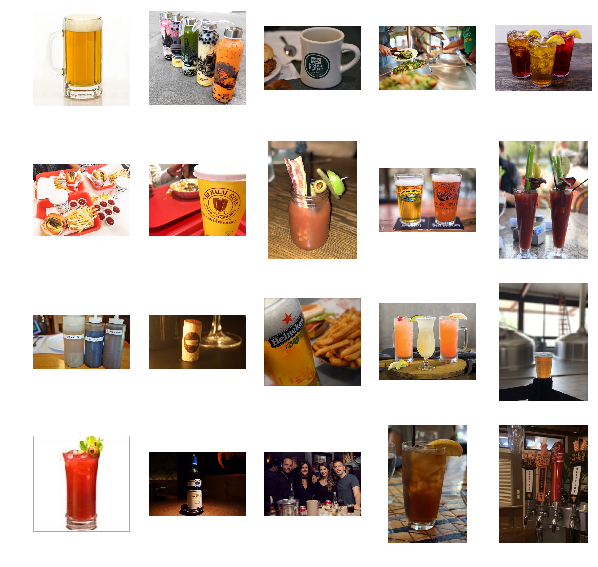

In [475]:
category = 6
cat_ind = (np.argmax(model_lda_b5_av_40.doc_topic_,axis=1) == category)
num_in_class = class_count_b5_av_40[category]
print(num_in_class)
if(num_in_class < 20):
    num_images = num_in_class
else:
    num_images = 20
with matplotlib.rc_context({'figure.figsize': [10,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    val = np.random.choice(range(0,num_in_class),size=(num_images),replace=False)
    print(val)
    for i,num in enumerate(range(0,num_images)):
        cat_names = names_subset[cat_ind] 
        img = PIL.Image.open(cat_names[val[i]])
        plt.subplot(4,5,i+1)
        plt.axis('off')
        plt.imshow(img)
        

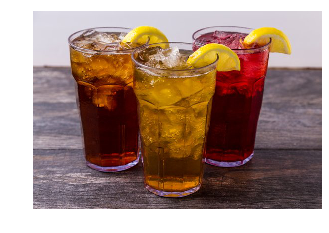

In [476]:
with matplotlib.rc_context({'figure.figsize': [30,25], 'axes.titlesize': 10}):
    fig = plt.figure()
    img = PIL.Image.open(names_subset[cat_ind][47])
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(img)

In [287]:
class_count_b2_av

Counter({0: 1147, 2: 12, 5: 82, 6: 18, 7: 16, 8: 85, 9: 640})

In [471]:
image_num = 55
#cat 11, im = 1224

NameError: name 'model_lda' is not defined

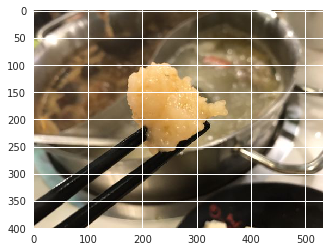

In [472]:
img = PIL.Image.open(names_subset[image_num])
plt.imshow(img)
class_val = np.argmax(model_lda.doc_topic_[image_num,:])
print(class_val)

In [88]:
print(np.argsort(model_lda.doc_topic_[image_num,:]))
model_lda.doc_topic_[image_num,:]

[ 0 17 16 12 11 18  8  9  6  4  3  2  1 19  5 10 13 14 15  7]


array([0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.1375, 0.0125, 0.1375,
       0.0125, 0.0125, 0.1375, 0.0125, 0.0125, 0.1375, 0.1375, 0.1375,
       0.0125, 0.0125, 0.0125, 0.0125])

<Container object of 20 artists>

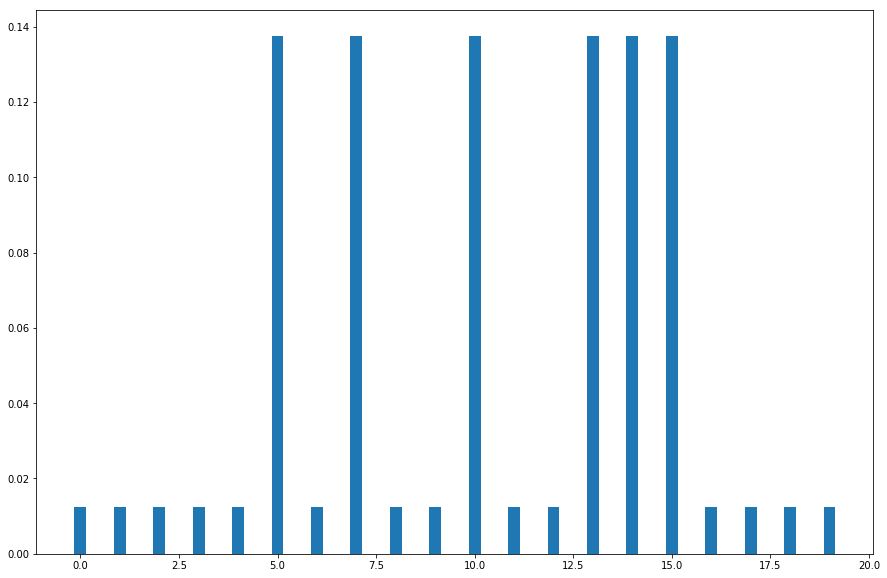

In [89]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,20),model_lda.doc_topic_[image_num,:],width=0.3)

In [326]:
category = 9
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]

In [327]:
len(indx)

640

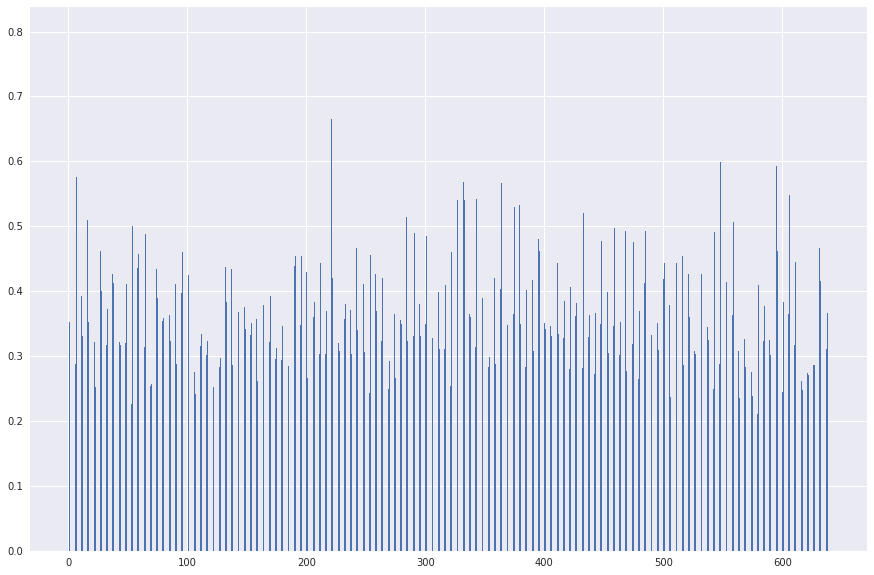

In [328]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,class_count_b2_av[category]),np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),width=0.3)
label_cat = indx
for i,label in enumerate(range(0,class_count_b2_av[category])):

    x = i
    y = np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1)[i]
    #plt.annotate(label_cat[i],xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')


In [331]:
np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1).shape

(640,)

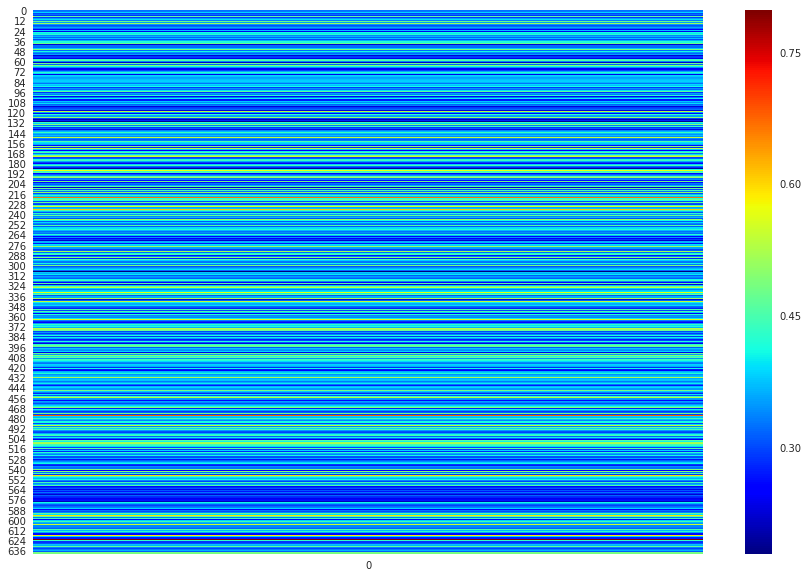

In [341]:
category = 9
sns.set()
num_in_class = class_count_b2_av[category]
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(np.reshape(np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),(num_in_class,1)),cmap="jet")

In [137]:
import seaborn as sns

In [30]:
model_lda.doc_topic_

array([[1.92678227e-04, 1.92678227e-04, 1.92678227e-04, ...,
        4.04624277e-03, 2.11946050e-03, 1.75337187e-02],
       [9.22844175e-03, 1.51285930e-04, 1.51285930e-04, ...,
        1.51285930e-04, 1.15128593e-01, 1.51285930e-04],
       [1.18623962e-04, 9.73902728e-02, 1.18623962e-04, ...,
        1.18623962e-04, 1.30486358e-03, 1.18623962e-04],
       ...,
       [1.00100100e-04, 3.51351351e-02, 3.61361361e-02, ...,
        1.00100100e-04, 1.01201201e-01, 1.23223223e-01],
       [1.26422250e-04, 1.26422250e-04, 1.26422250e-04, ...,
        1.26422250e-04, 1.26422250e-04, 8.97597977e-03],
       [1.29701686e-04, 1.15564202e-01, 1.29701686e-04, ...,
        7.91180285e-03, 5.07133593e-02, 1.29701686e-04]])

In [87]:
topic_ordered = np.argsort(np.argmax(model_lda.doc_topic_,axis=1))

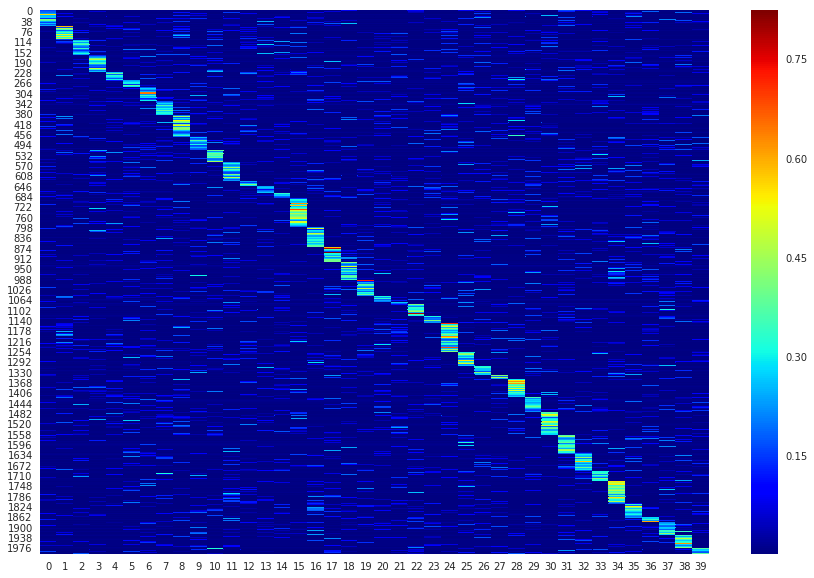

In [211]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_max.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_max.doc_topic_ [topic_ordered,:],cmap="jet")

## rich get richer - bigger clusters get bigger over time and smaller clusters get smaller (because of way update prior) so when topic number increases, the size of the clusters are relatively similar and can therefore find drink topics are more low level similarities

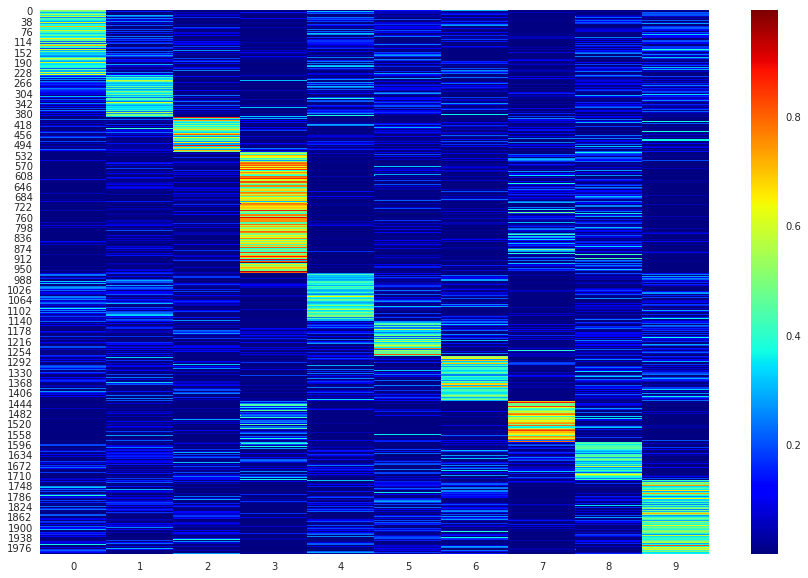

In [381]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av.doc_topic_ [topic_ordered,:],cmap="jet")

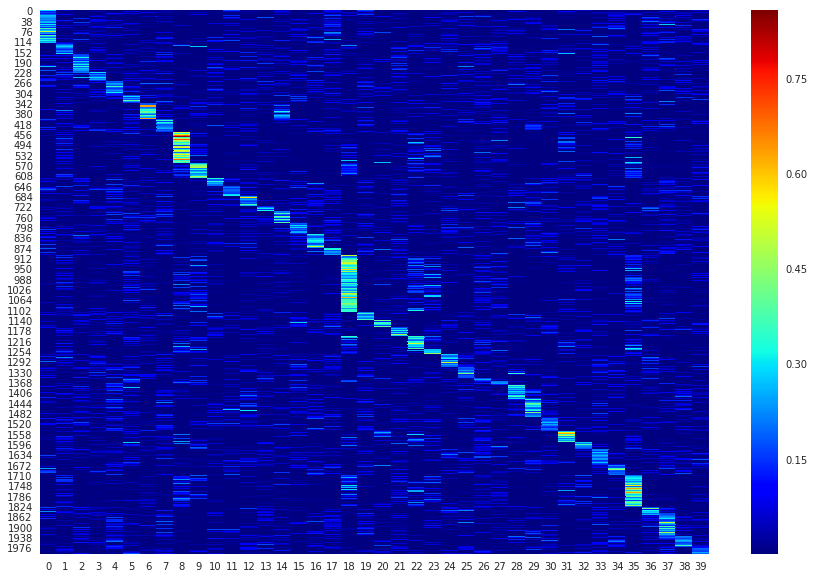

In [437]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av_40.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av_40.doc_topic_ [topic_ordered,:],cmap="jet")

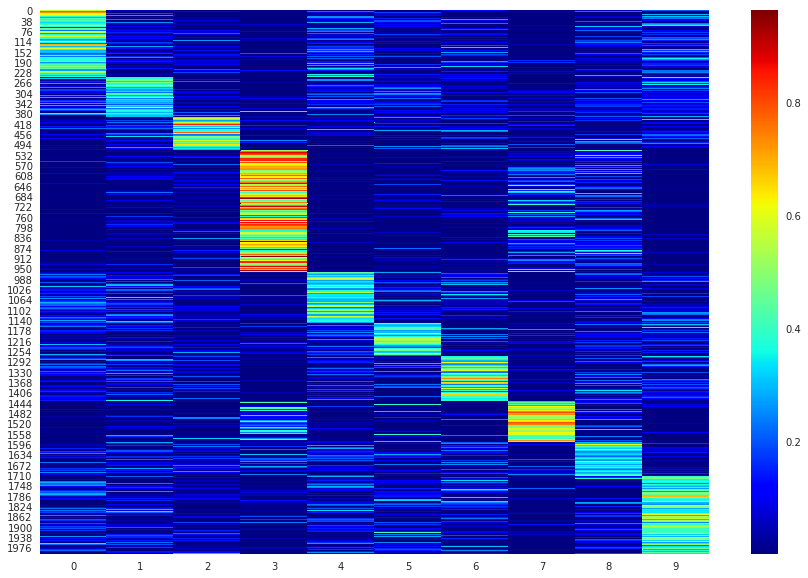

In [191]:
sns.set()
topic_ordered = np.argsort(np.argmax(topic_b5_av_c,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(topic_b5_av_c [topic_ordered,:],cmap="jet")

determining modesl given some words for a given topic 